<img src="https://heig-vd.ch/docs/default-source/doc-global-newsletter/2020-slim.svg" alt="Logo HEIG-VD" style="width: 80px;" align="right"/>

# Cours APN - Labo 3 : Groupement hiérarchique de documents

## Résumé
Le but de ce laboratoire est d'appliquer un algorithme de groupement hiérarchique à des résumés de films.  Vous afficherez les résultats et observerez quels paramètres permettent d'obtenir un groupement convenable, car il n'y a pas de vérité-terrain dans ces données.

Les étapes proposées sont les suivantes :
  1. Préparation des documents : pré-traitement des textes des résumés
  2. Création des représentations vectorielles de chaque résumé
  3. Groupement hiérarchique, affichage du dendrogramme, et discussion

## 1. Préparation des documents

Dans ce labo, vous utiliserez les titres et résumés des 100 films classiques (*référence anonymisée*) qui vous sont fournis sur Cyberlearn dans le fichier `movie_data.csv` sur deux colonnes : titres et résumés.

Dans cette première partie, vous allez transformer les textes des résumés pour réduire la diversité du vocabulaire.  Un ensemble de fonctions de préparation vous est fourni dans la librairie `utils.py` (également sur Cyberlearn) et il est conseillé de les lire et de les utiliser.

In [92]:
import itertools

import numpy as np
import pandas as pd
import utils # librairie avec des fonctions de pré-traitement des textes
# elle fait appel à la librairie NLTK (ce qui affiche plusieurs messages)

a. Veuillez charger les données des films depuis le fichier `movie_data.csv` dans une _DataFrame_ intitulée `movie_data`.  Combien de lignes et colonnes a-t-elle et quels sont les intitulés des colonnes ?

In [93]:
movie_data = pd.read_csv("movie_data.csv")
movie_data

,Title,Synopsis
0,The Godfather,"In late summer 1945, guests are gathered for t..."
1,The Shawshank Redemption,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,Schindler's List,The relocation of Polish Jews from surrounding...
3,Raging Bull,"The film opens in 1964, where an older and fat..."
4,Casablanca,"In the early years of World War II, December 1..."
...,...,...
95,Rebel Without a Cause,Shortly after moving to Los Angeles with his p...
96,Rear Window,"L.B. ""Jeff"" Jeffries (James Stewart) recuperat..."
97,The Third Man,"Sights of Vienna, Austria, flash across the sc..."
98,North by Northwest,"At the end of an ordinary work day, advertisin..."


b. Veuillez normaliser le texte de chaque résumé en appliquant plusieurs des fonctions fournies dans `utils.py` (pour cela, vous devez examiner ce fichier).  Veuillez stocker les textes normalisés dans une nouvelle colonne de la _DataFrame_.   Il n'est pas nécessaire de tokeniser les textes normalisés, car le _vectorizer_ de sklearn le fera plus loin. 

In [94]:
def text_filter(text):
    for f in (utils.remove_stopwords, utils.remove_punctuation, utils.remove_non_alphabetic):
        text = f(text)
    return text

In [95]:
texts = movie_data["Synopsis"]

movie_data["NormalizedSynopsis"] = texts.apply(text_filter).apply(utils.lemmatize_text)

c. Veuillez analyser la longueur des résumés, avant et après le pré-traitement, grâce au _5-number summary_ de chaque distribution.  Veuillez commenter brièvement l'évolution de la distribution suite au pré-traitement.

In [96]:
synopsis_lengths = movie_data[["Synopsis", "NormalizedSynopsis"]].applymap(len)
synopsis_lengths.describe().loc[["min", "25%", "50%", "75%", "max"]]

,Synopsis,NormalizedSynopsis
min,1071.00,709.00
25%,4378.75,2822.25
50%,6528.50,4182.00
75%,11417.50,7239.50
max,34021.00,22090.00


**Réponse:** On constate que la longueur des résumés normalisés est bien moindre que celle des résumés originaux (médiane des longueurs réduite d'environ 36%)

d. Veuillez afficher un extrait du résumé d'un film *avant* et *après* le pré-traitement et commenter brièvement le résultat.

In [97]:
print("Original:")
print(movie_data.loc[0]["Synopsis"][0:200])
print("Normalized:")
print(movie_data.loc[0]["NormalizedSynopsis"][0:200])

Original:
In late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone's daughter Connie (Talia Shire) and Carlo Rizzi (Gianni Russo). Vito (Marlon Brando), the head of the Corleone M
Normalized:
in late summer guest gather wed reception don vito corleone s daughter connie talia shire carlo rizzi gianni russo vito marlon brando head corleone mafia family know friend associate godfather he tom 


**Réponse:** On constate qu'il n'y a effectivement plus de chiffres, ponctuation et de _stop_words_, avec par example la disparition respective de 1945, la virgule qui le suit ainsi que le verbe _are_ un peu après. Les mots restants ont subit une lemmatisation, ils sont en minuscules et transformés en une forme plus courte (infinitif pour les verbes, singulier pour les mots, etc).

## 2. Création des représentations vectorielles

Dans cette partie, vous allez créer pour chaque film une représentation vectorielle avec les coefficients TF-IDF, comme vous l'avez appris en PCD, en utilisant `TfidfVectorizer`.  Veuillez justifier brièvement votre choix de paramètres.

a. Veuillez créer les vecteurs dans un tableau appelé `feature_matrix`, avec autant de lignes que de films.

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [99]:
vectorizer = TfidfVectorizer()
feature_matrix = vectorizer.fit_transform(movie_data["NormalizedSynopsis"])
np.shape(feature_matrix)

(100, 11159)

b. Quel est le nombre de colonnes du tableau `feature_matrix`. Pourquoi ?

**Réponse**: Il y a 100 colonnes, une par résumé de film

c. Veuillez afficher les mots correspondant aux 20 premières dimensions de `feature_matrix`.  (Note : les dimensions sont classées par ordre alphabétique des mots.)

In [110]:
print(vectorizer.get_feature_names_out()[:20])

['00am' '101st' '11th' '13th' '15th' '16th' '1800s' '18th' '1900s' '1920s'
 '1930s' '1940s' '1950s' '1960s' '1st' '20th' '21st' '25th' '2nd' '30s']


## 3. Groupement hiérarchique
Dans cette section, vous utiliserez un algorithme de groupement hiérarchique et vous afficherez les résultats sous forme de dendrogramme.  Les fonctions utilisées proviendront de `scipy`, comme recommandé par sklearn sous [Plot Hierarchical Clustering Dendrogram](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html).  Merci de suivre les indications et répondre aux questions suivantes.

In [121]:
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import single, complete, average, ward
from scipy.cluster.hierarchy import dendrogram, cut_tree
import matplotlib.pyplot as plt
%matplotlib inline

a. Générer une matrice des distances entre paires de résumés, en utilisant les représentations vectorielles obtenues ci-dessus et la métrique [sklearn.metrics.pairwise.cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html).  Attention, le cosinus étant une similarité, prendre _1-cosinus_ pour obtenir des distances. 

In [137]:
distances = 1.0 - cosine_similarity(feature_matrix, feature_matrix)
distances

array([[-2.22044605e-16,  9.74404629e-01,  9.68092195e-01, ...,
         9.77767328e-01,  9.67372968e-01,  9.68748430e-01],
       [ 9.74404629e-01, -2.22044605e-16,  9.66221222e-01, ...,
         9.77112815e-01,  9.71981910e-01,  9.80682407e-01],
       [ 9.68092195e-01,  9.66221222e-01, -2.22044605e-16, ...,
         9.80899554e-01,  9.78223661e-01,  9.78885435e-01],
       ...,
       [ 9.77767328e-01,  9.77112815e-01,  9.80899554e-01, ...,
         2.22044605e-16,  9.60837032e-01,  9.88287112e-01],
       [ 9.67372968e-01,  9.71981910e-01,  9.78223661e-01, ...,
         9.60837032e-01, -2.22044605e-16,  9.81992334e-01],
       [ 9.68748430e-01,  9.80682407e-01,  9.78885435e-01, ...,
         9.88287112e-01,  9.81992334e-01, -2.22044605e-16]])

b. Veuillez utiliser la méthode **ward** de [scipy.cluster.hierarchy](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) qui effectue le groupement hiérarchique à partir d'une matrice des distances.  Quel est le résultat retourné par la méthode ?

In [139]:
grouping = ward(distances)

c. Afficher le dendrogramme avec la fonction [scipy.cluster.hierarchy.dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) qui utilise la matrice de liens.  Utiliser l'exemple donné en bas de la page [dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html).  Veuillez afficher un dendrogramme aussi lisible que possible, et en particulier veuillez étiqueter chaque feuille avec le nom du film correspondant.

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [75.0, 75.0, 85.0, 85.0],
  [95.0, 95.0, 105.0, 105.0],
  [115.0, 115.0, 125.0, 125.0],
  [135.0, 135.0, 145.0, 145.0],
  [120.0, 120.0, 140.0, 140.0],
  [155.0, 155.0, 165.0, 165.0],
  [175.0, 175.0, 185.0, 185.0],
  [195.0, 195.0, 205.0, 205.0],
  [215.0, 215.0, 225.0, 225.0],
  [200.0, 200.0, 220.0, 220.0],
  [235.0, 235.0, 245.0, 245.0],
  [255.0, 255.0, 265.0, 265.0],
  [240.0, 240.0, 260.0, 260.0],
  [295.0, 295.0, 305.0, 305.0],
  [285.0, 285.0, 300.0, 300.0],
  [275.0, 275.0, 292.5, 292.5],
  [315.0, 315.0, 325.0, 325.0],
  [335.0, 335.0, 345.0, 345.0],
  [320.0, 320.0, 340.0, 340.0],
  [283.75, 283.75, 330.0, 330.0],
  [365.0, 365.0, 375.0, 375.0],
  [355.0, 355.0, 370.0, 370.0],
  [395.0, 395.0, 405.0, 405.0],
  [385.0, 385.0, 400.0, 400.0],
  [362.5, 362.5, 392.5, 392.5],
  [306.875, 306.875, 377.5, 377.5],
  [250.0, 250.0, 342

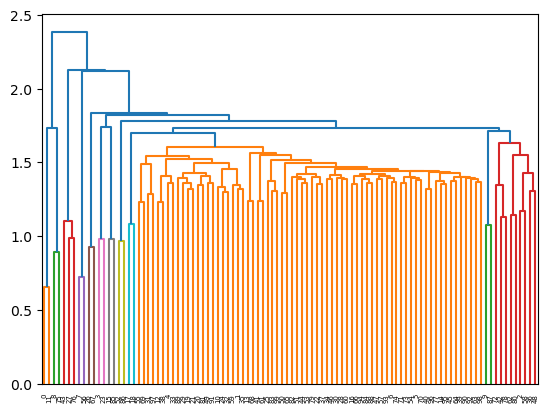

In [140]:
dendrogram(grouping)

d. Veuillez essayer une deuxième méthode de groupement hiérarchique et afficher son dendrogramme.  Comment se compare-t-il au précédent ?  Le trouvez-vous meilleur, moins bon, ou similaire ? 

e. Quel est le nombre de groupes qui vous semble optimal, pour la méthode de votre choix ?  Pourquoi ?

## 4. Affichage des groupes et de leurs mots-clés

Dans cette section, vous utiliserez la méthode de groupement et le nombre de groupes choisis dans la section précédente.  Pour obtenir un nombre de groupe fixé à l'avance à partir de la matrice *linkage* obtenue au 3b ou 3d, vous pouvez utiliser la fonction `cut_tree`de Scipy. 

a. Pour chaque groupe, veuillez afficher :
* le numéro du groupe (commençant par 1)
* les titres des films du groupe
* le nombre de films dans le groupe

b. Pour chacun des groupes précédents, veuillez afficher les six meilleurs mots-clés qui le caractérisent.  On définit les mots-clés comme les mots (donc les dimensions résultant du `TfidfVectorizer`) qui ont les plus grands coefficients dans le centre de gravité du groupe.

c. D'après les titres des films (et vos connaissances), les mots-clés obtenus sont-ils représentatifs des groupes ?

**Fin du Labo 3.**  Veuillez nettoyer ce notebook, afficher les résultats et les commentaires demandés, l'enregistrer, et le soumettre comme devoir sur Cyberlearn.